In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Homogeneous Neumann B.C on a Circular Boundary

If we want to include both Dirichlet B.C and Neumann B.C. on arbitrarily-shaped boundaries, the trial solution will look more complex. In the following equation:

**euqtion (10) in McFall paper**

* $g(\vec{x})$ is $g(\vec{x})$ in $\hat n(\vec{x}) \cdot \nabla u = g(\vec{x})$, where $\hat n(\vec{x})$ is the normal vector at $\vec{x}$
* $L_D(\vec{x})$ indicates how far away is $\vec{x}$ from the Dirichlet booundary condition, $L_D(\vec{x}) = 0$ on Dirichlet boundary. 
* $L_M(\vec{x})$ indicates how far away is $\vec{x}$ from the Neumann booundary condition, $L_D(\vec{x}) = 0$ on Neumann boundary. 
* $N$ is the output of the neural net
* $x_k$ is the $k-th$ dimension of $\vec{x}$
* $n_k$ is the $k-th$ dimension of the normal vector at $\vec{x}$ (on Neumann boundary, but should also be defined outside the Neumann boundary so that out trial solution can be evaluated outside the Neumann boundary as well)
* $F$ is $L_D(\vec{x})N$
* The $K(1-e^{1-L_M(\vec{x})})$ is for avoiding division by zero.


For a circular Neumann boundary on the circle $||\vec{x}||^2 = r^2$, the above trial solution can be simplified because:

* $L_D(\vec{x})$ is just 1 every where and $A_D(\vec)$ doesn't matter. (There is not Dirichlet boundary)
* $L_M(\vec{x})$ is just $r^2 - ||\vec{x}||^2$
* $\hat n(\vec{x})$ is just $\frac{1}{r} \vec{x}$

Unfortunately, I haven't get this part working yet...

In [2]:
def _nn_output(net, dimensions):
    original_shape  = dimensions[0].shape
    dimensions = torch.cat(tuple(d.reshape(-1, 1) for d in dimensions), 1)
    output = net(dimensions)
    return output.reshape(original_shape)

In [3]:
class CircularNeumannHomogeneous:
    
    def __init__(self, r_dirichlet, val_dirichlet, r_neumann, val_neumann, K=5.0, alpha=5.0):
        self.r_dirichlet = r_dirichlet
        self.val_dirichlet = val_dirichlet
        self.r_neumann = r_neumann
        self.val_neumann = val_neumann
        self.K = K
        self.alpha = alpha
    
    def L_D(self, dimensions):
        return self.r_dirichlet**2 - sum(d**2 for d in dimensions)
    
    def L_M(self, dimensions):
        return self.r_neumann**2 - sum(d**2 for d in dimensions)
    
    def A_D(self, dimensions):
        return self.val_dirichlet
    
    def g(self, dimensions):
        return self.val_neumann
    
    def normal_vector(self, dimensions):
        return dimensions
    
    def F(self, dimensions):
        return self.L_D(dimensions) * _nn_output(net, dimensions)

    def A_M(self, net, dimensions):
        Fs = self.F(dimensions)
        L_Ds = self.L_D(dimensions)
        L_Ms = self.L_M(dimensions)
        nxs = self.normal_vector(dimensions)
        
        numer = self.g(dimensions) - sum(
            nk * diff(Fs, d) for nk, d in zip(nxs, dimensions)
        ) # diff(A_D, d) is omitted here because it's always 0.0
        denom = L_Ds * sum(
            nk * diff(L_Ms, d) for nk, d in zip(nxs, dimensions)
        ) + self.K * (1-torch.exp(-self.alpha * L_Ms))
            
        return L_Ds * L_Ms * numer / denom 
        
    def enforce(self, net, *dimensions):
        return self.A_D(dimensions) + self.A_M(net, dimensions) + self.F(dimensions)
    
    def set_impose_on(self, ith):
        self.ith = ith

Poisson in circular domain where

$$
\partial_x^2 u + \partial_y^2 u = 4
$$

$$
x^2 + y^2 \leq 1
$$

s.t.

$$
u(x, y) = \frac{1}{4}, x^2 + y^2 = \frac{1}{4} \\
\hat n((x, y)) \cdot \nabla u = 2, x^2 + y^2 = 1
$$

Solution is

$$
u(x, y) = x^2 + y^2
$$

In [4]:
def solution_analytical_poisson(xx, yy):
    return xx**2 + yy**2

In [5]:
class PredefinedExampleGenerator2D:
    
    def __init__(self, xs, ys):
        self.size = len(xs)
        x = torch.tensor(xs, requires_grad=True, dtype=torch.float32)
        y = torch.tensor(ys, requires_grad=True, dtype=torch.float32)
        self.x, self.y = x.flatten(), y.flatten()

    def get_examples(self):
        return self.x, self.y

In [6]:
xs, ys = np.linspace(-1.0, 1.0, 201), np.linspace(-1.0, 1.0, 201)
xx, yy = np.meshgrid(xs, ys)
in_domain = (xx**2 + yy**2 < 1.0) & (xx**2 + yy**2 > .25)
xx, yy = xx[in_domain], yy[in_domain]
train_gen = PredefinedExampleGenerator2D(xx, yy)

xs, ys = np.linspace(-1.0, 1.0, 32), np.linspace(-1.0, 1.0, 32)
xx, yy = np.meshgrid(xs, ys)
in_domain = (xx**2 + yy**2 < 1.0) & (xx**2 + yy**2 > .25)
xx, yy = xx[in_domain], yy[in_domain]
valid_gen = PredefinedExampleGenerator2D(xx, yy)

<IPython.core.display.Javascript object>


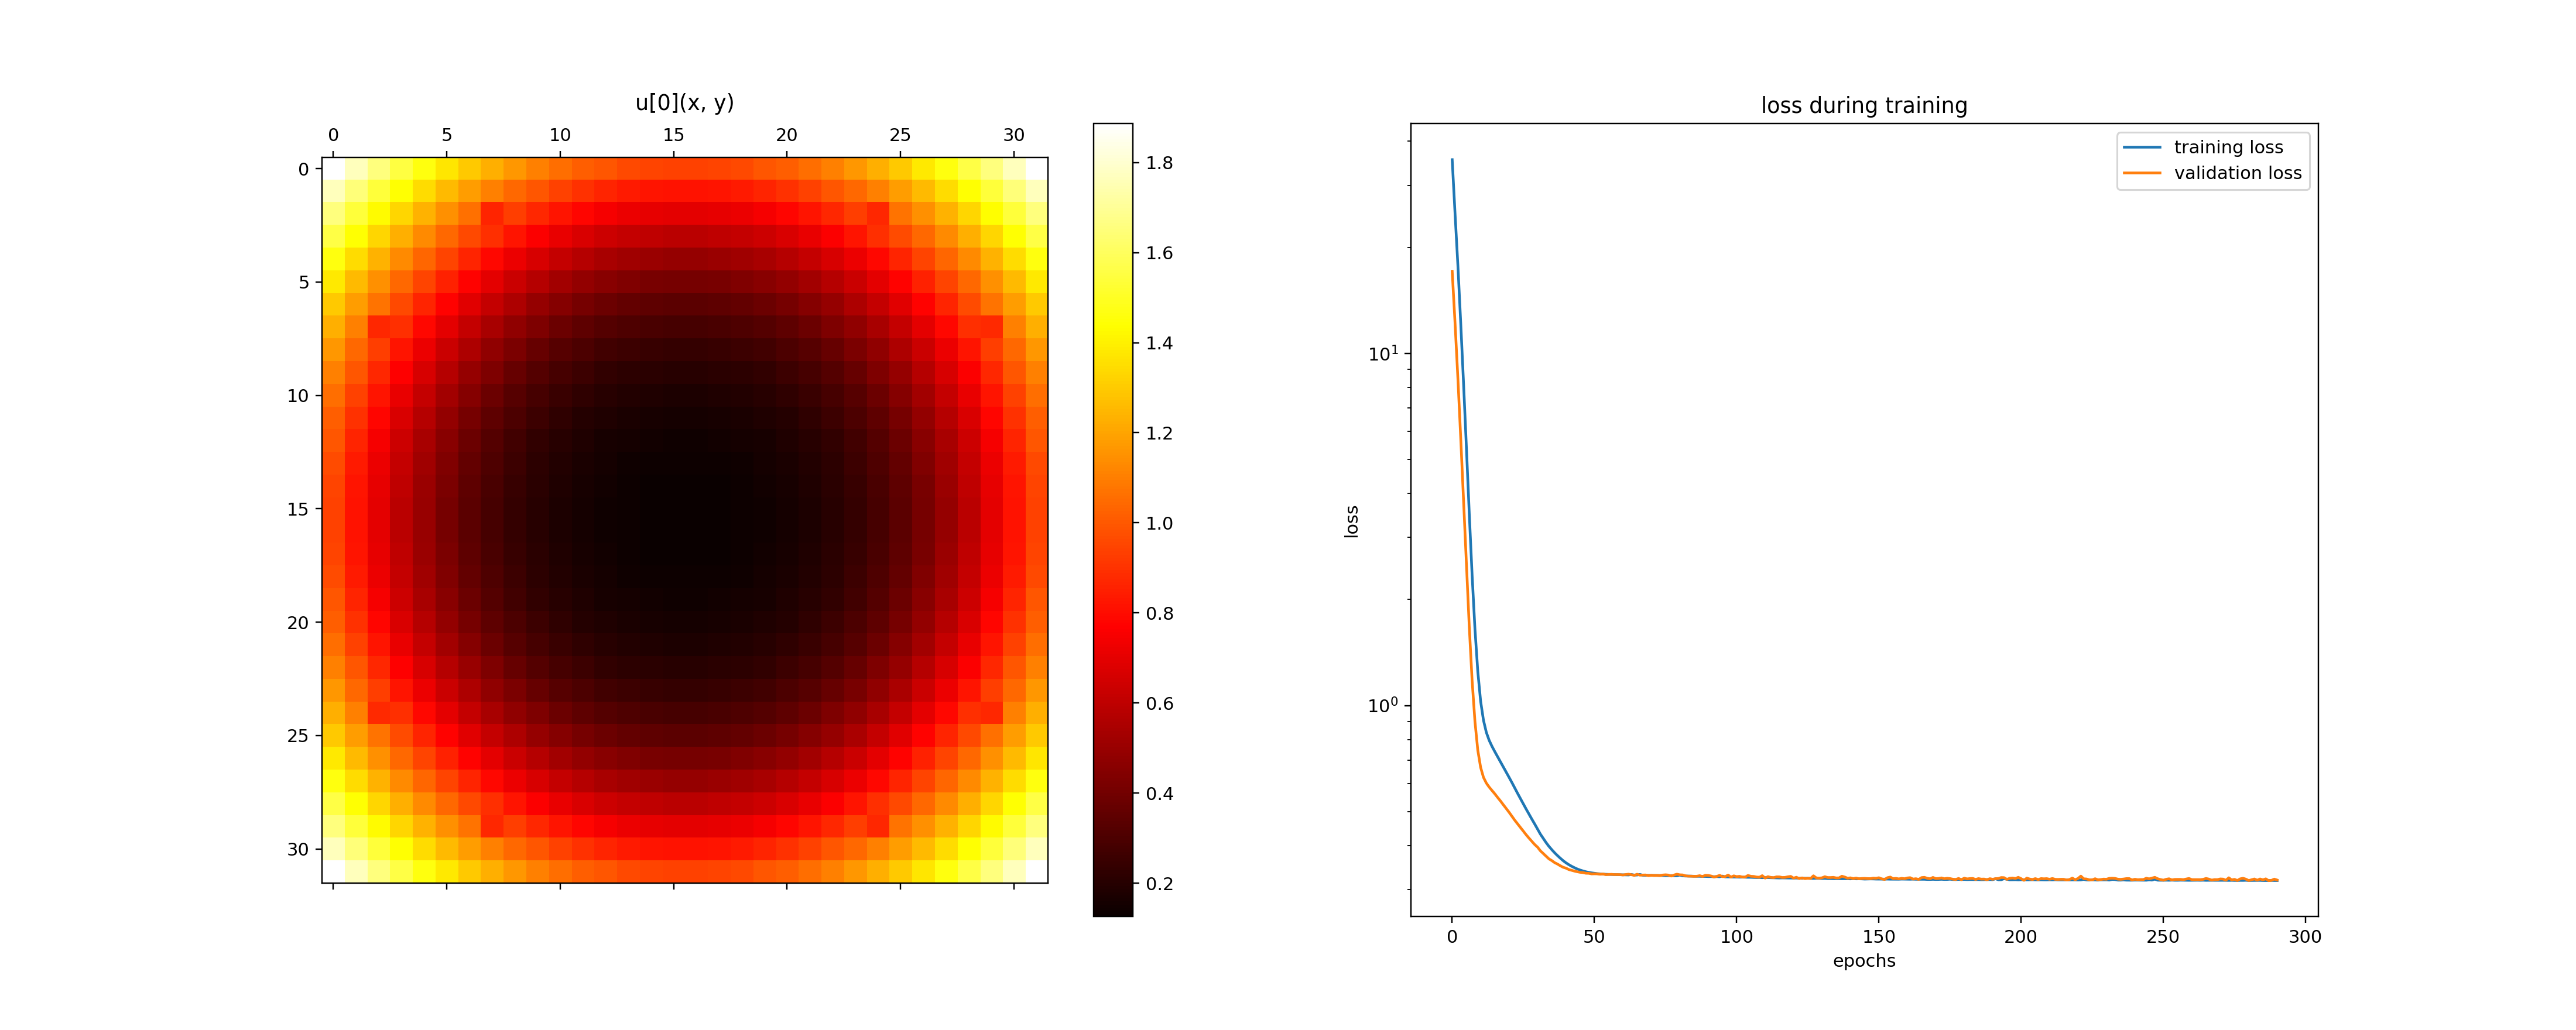

In [7]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 4
bc  = CircularNeumannHomogeneous(r_dirichlet=0.5, val_dirichlet=0.25, r_neumann=1.0, val_neumann=2.0)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Softplus)
adam = optim.Adam(params=net.parameters(), lr=1e-5)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(-1, -1), xy_max=(1, 1),
    net=net, optimizer=adam, 
    train_generator=train_gen, valid_generator=valid_gen,
    max_epochs=300, batch_size=256,
    monitor=Monitor2D(check_every=10, xy_min=(-1, -1), xy_max=(1, 1))
)

<IPython.core.display.Javascript object>


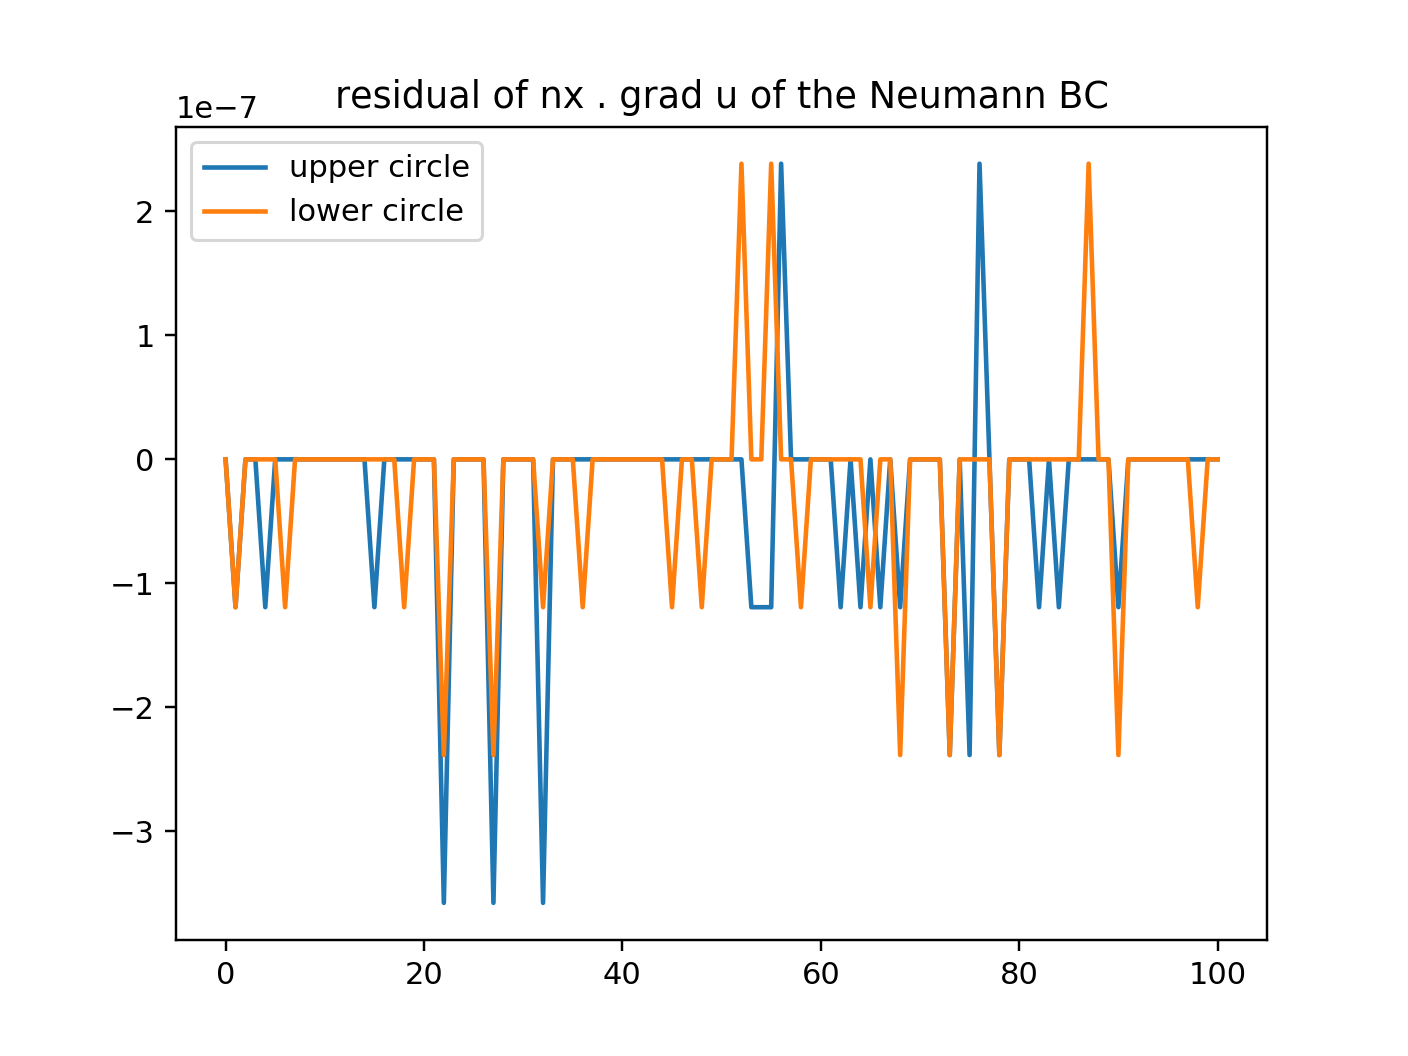

In [8]:
%matplotlib notebook
xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(nxgradu.detach().numpy() - 2.0, label='upper circle')

xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = -np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(nxgradu.detach().numpy() - 2.0, label='lower circle')
plt.title('residual of nx . grad u of the Neumann BC')
plt.legend();

<IPython.core.display.Javascript object>


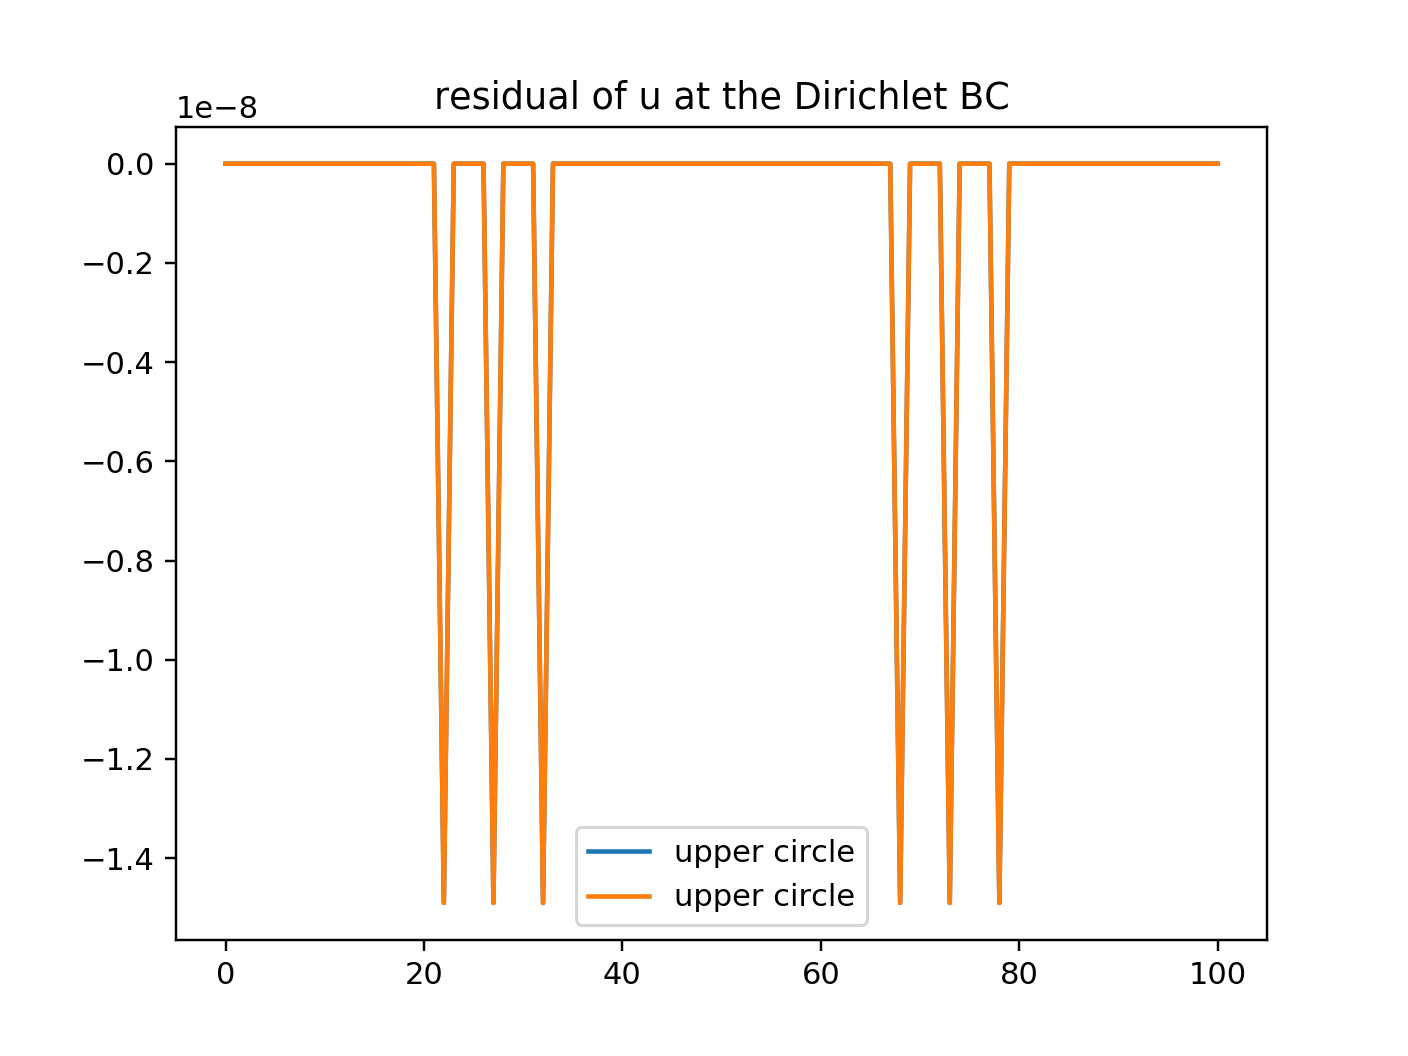

In [9]:
%matplotlib notebook
xs = np.linspace(-0.5, 0.5, 101, dtype=np.float32)
ys = np.sqrt(0.25-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(us.detach().numpy() - 0.25, label='upper circle')

xs = np.linspace(-0.5, 0.5, 101, dtype=np.float32)
ys = -np.sqrt(0.25-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
plt.plot(us.detach().numpy() - 0.25, label='upper circle')
plt.title('residual of u at the Dirichlet BC')
plt.legend();

<IPython.core.display.Javascript object>


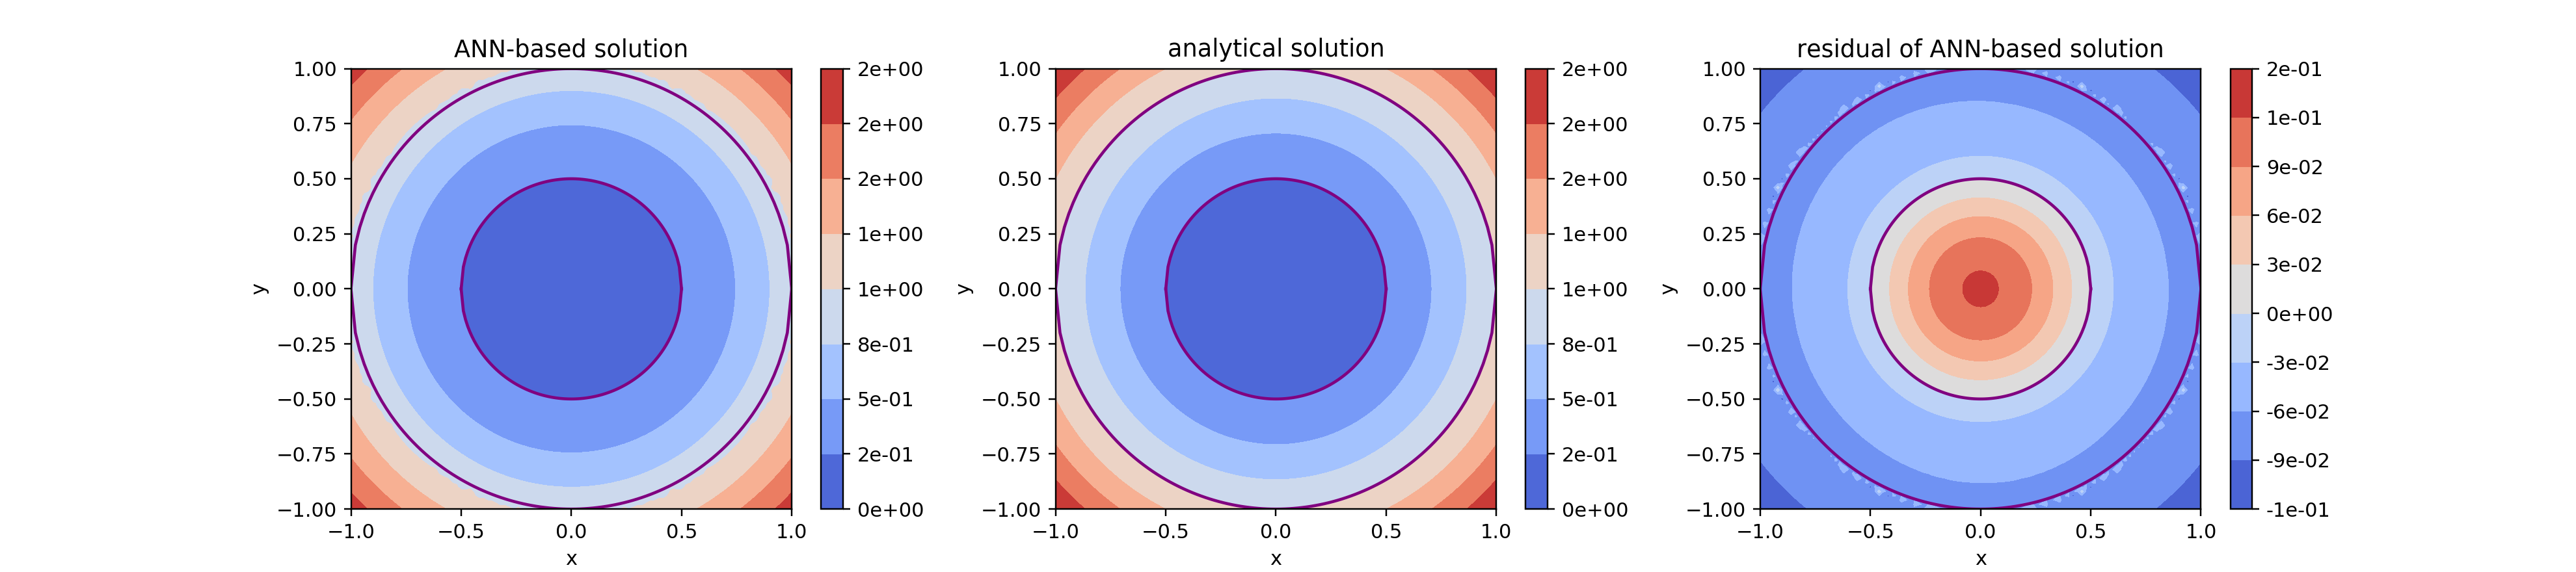

In [10]:
xs, ys = torch.linspace(-1.0, 1.0, 101, requires_grad=True), torch.linspace(-1.0, 1.0, 101, requires_grad=True)
xx, yy = torch.meshgrid(xs, ys)
sol_net = solution_neural_net_poisson(xx, yy).detach().numpy()
xx, yy = xx.detach().numpy(), yy.detach().numpy()
sol_ana = solution_analytical_poisson(xx, yy)

fig = plt.figure(figsize=(18, 4))

ax1 = fig.add_subplot(131)
cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('ANN-based solution')
cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)
ax1.plot(np.linspace(-1, 1, 101),  np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax1.plot(np.linspace(-1, 1, 101), -np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax1.plot(np.linspace(-.5, .5, 101),  np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')
ax1.plot(np.linspace(-.5, .5, 101), -np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')

ax2 = fig.add_subplot(132)
cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('analytical solution')
cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)
ax2.plot(np.linspace(-1, 1, 101),  np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax2.plot(np.linspace(-1, 1, 101), -np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax2.plot(np.linspace(-.5, .5, 101),  np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')
ax2.plot(np.linspace(-.5, .5, 101), -np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')

ax3 = fig.add_subplot(133)
cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title('residual of ANN-based solution')
cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)
ax3.plot(np.linspace(-1, 1, 101),  np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax3.plot(np.linspace(-1, 1, 101), -np.sqrt(1.0-np.linspace(-1, 1, 101)**2), color='purple')
ax3.plot(np.linspace(-.5, .5, 101),  np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')
ax3.plot(np.linspace(-.5, .5, 101), -np.sqrt(.25-np.linspace(-.5, .5, 101)**2), color='purple')

<IPython.core.display.Javascript object>


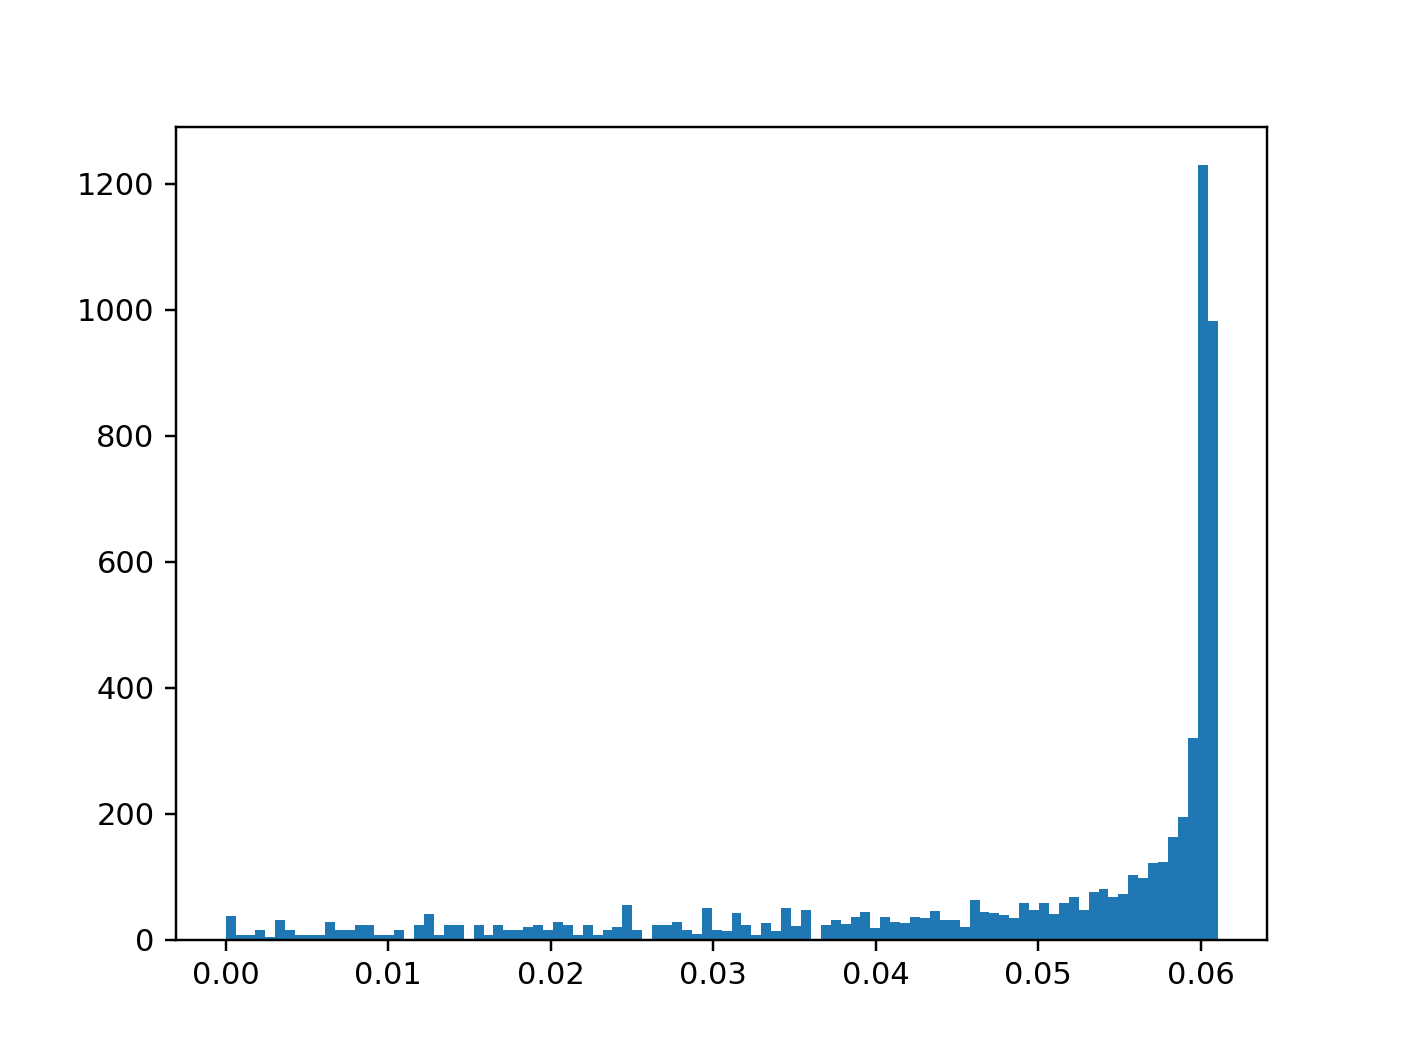

In [11]:
in_domain = (xx**2 + yy**2 < 1.0) & (xx**2 + yy**2 > .25)
residual = (sol_net-sol_ana)
plt.hist(np.abs(residual[in_domain]), bins=100);